In [1]:
# 1. Import thư viện cần thiết
# from google.colab import drive
# drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Bidirectional

In [107]:
# 2. Đọc file csv và gắng index với giá Close
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FPT Historical Data 10 years.csv')
df = pd.read_csv('../Datasets/INTC Historical Data.csv')
df1=df.reset_index()['Price']
df.size

11277

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [78]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [79]:
len(val_data)

162

In [80]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [81]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [82]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [83]:
# 8. Define LSTM Model
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_step,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add a bidirectional LSTM layer
model.add(Bidirectional(LSTM(100, activation='relu')))

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [84]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 3s 89ms/step - loss: 0.0976 - val_loss: 0.0136
Epoch 2/100
14/14 [==============================] - 1s 68ms/step - loss: 0.0128 - val_loss: 0.0227
Epoch 3/100
14/14 [==============================] - 1s 64ms/step - loss: 0.0093 - val_loss: 0.0123
Epoch 4/100
14/14 [==============================] - 1s 63ms/step - loss: 0.0080 - val_loss: 0.0143
Epoch 5/100
14/14 [==============================] - 1s 64ms/step - loss: 0.0073 - val_loss: 0.0136
Epoch 6/100
14/14 [==============================] - 1s 66ms/step - loss: 0.0068 - val_loss: 0.0123
Epoch 7/100
14/14 [==============================] - 1s 65ms/step - loss: 0.0063 - val_loss: 0.0096
Epoch 8/100
14/14 [==============================] - 1s 69ms/step - loss: 0.0059 - val_loss: 0.0097
Epoch 9/100
14/14 [==============================] - 1s 69ms/step - loss: 0.0055 - val_loss: 0.0064
Epoch 10/100
14/14 [==============================] - 1s 69ms/step - loss: 0.0052 - val_loss: 0.0052

In [85]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 12ms/step


In [86]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [87]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))

In [88]:
# 13. Dự báo 30 ngày tiếp theo

# n_steps=100
# x_input=val_data[60:].reshape(1,-1)

n_steps=time_step
x_input=val_data[-n_steps:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
i=0
while(i<30):
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.10399686]
101
1 day input [0.06105118 0.08790452 0.10121643 0.10420014 0.11361028 0.12370897
 0.11957769 0.10787239 0.08974065 0.08078953 0.09915079 0.12324994
 0.11521689 0.11016755 0.11911866 0.07482213 0.0700023  0.07711728
 0.09570806 0.12141382 0.12439752 0.08698646 0.09524902 0.07665825
 0.06495295 0.06655956 0.08377324 0.08583888 0.09065871 0.07574019
 0.06219876 0.02662382 0.0130824  0.01629562 0.00550838 0.
 0.00068855 0.00986918 0.02983704 0.03442736 0.02501721 0.01445949
 0.0247877  0.03534542 0.05324765 0.04705072 0.07137939 0.08056002
 0.1211843  0.11269222 0.0977737  0.0817076  0.07413358 0.09478999
 0.10236401 0.09823273 0.1007574  0.15193941 0.1650218  0.17833372
 0.18338306 0.18820289 0.18200597 0.18154694 0.17489098 0.17098921
 0.16341519 0.16593987 0.16043149 0.16616938 0.1590544  0.14344733
 0.13679137 0.12393849 0.10924948 0.09134726 0.09524902 0.1138398
 0.14138168 0.12393849 0.11177416 0.13197154 0.14551297 0.13977507
 0.13472573 0.11934818 0.11636447 0.090888

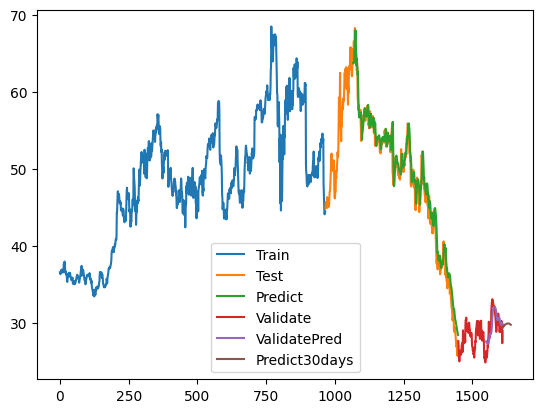

In [89]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_pre_data_index = pd.RangeIndex(start=train_size+n_steps+1, stop=train_size+test_size, step=1)
plt.plot(test_pre_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_pre_data_index = pd.RangeIndex(start=train_size+test_size+n_steps+1, stop=train_size+test_size+val_size, step=1)
plt.plot(val_pre_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1), stop=len(df1)+30, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [90]:

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 29.77196138403026
Testing RMSE: 49.17554242986662


In [91]:
print(scaler.inverse_transform(lst_output)[:10, 0])

[29.4311431  29.60793278 29.51940907 29.68150572 29.68039096 29.74481248
 29.74583634 29.79799008 29.79977972 29.83229351]


In [92]:
print(df['Price'].tail(10))

1601    29.80
1602    29.22
1603    28.87
1604    29.68
1605    29.93
1606    30.28
1607    29.51
1608    29.00
1609    27.40
1610    29.00
Name: Price, dtype: float64


In [106]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

# pred_ind = list(range(len(df1), len(df1)+30))
# x_train_ind = list(range(0, train_size))
# x_test_ind = list(range(train_size, train_size+test_size))
# x_validation_ind = list(range(train_size+test_size, len(df1)))
# pred_ind = list(range(len(df1), len(df1)+30))

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data_index, y=scaler.inverse_transform(train_data)[:, 0], mode='lines+markers', marker=dict(size=4),  name='Train', marker_color='#1F77B4'))
fig.add_trace(go.Scatter(x=test_data_index,y=scaler.inverse_transform(test_data)[:, 0], mode='lines+markers', marker=dict(size=4), name='Test', marker_color='#FF7F0E'))
fig.add_trace(go.Scatter(x=test_pre_data_index,y=y_pred[:, 0], mode='lines+markers', marker=dict(size=4), name='Prediction', marker_color='#2CA02C'))
fig.add_trace(go.Scatter(x=val_data_index, y=scaler.inverse_transform(val_data)[:, 0], mode='lines+markers', marker=dict(size=4), name='Validate', marker_color='#D62728'))
fig.add_trace(go.Scatter(x=val_pre_data_index, y=y_pred_val[:, 0], mode='lines+markers', marker=dict(size=4), name='Validate', marker_color='#9569BE'))
fig.add_trace(go.Scatter(x=prediect_data_index, y=scaler.inverse_transform(lst_output)[:, 0], mode='lines+markers', marker=dict(size=4), name='Next30Day', marker_color='#000000'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',  
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),    
                  title_text = f'INTC CNN_Bi_LSTM data (6:3:1)', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

In [94]:
len(df1)

1611

In [95]:
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)

In [96]:
prediect_data_index

RangeIndex(start=1610, stop=1640, step=1)

In [97]:
prediect_data_index = pd.RangeIndex(start=len(df1), stop=len(df1)+30, step=1)

In [98]:
prediect_data_index

RangeIndex(start=1611, stop=1641, step=1)

In [99]:
len(val_data)

162

In [100]:
len(df1) - len(train_data) - len(test_data)

162

In [101]:
len(train_data) 

966

In [102]:
test_data_index

RangeIndex(start=966, stop=1449, step=1)

In [103]:
len(train_data) + len(test_data)

1449

In [104]:
val_data_index

RangeIndex(start=1449, stop=1611, step=1)

In [105]:
prediect_data_index

RangeIndex(start=1611, stop=1641, step=1)